In [2]:
import os
import glob
import argparse
import copy

import numpy as np
import astropy.units as u
import astropy.constants as c
import astropy.coordinates as aco
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from pyuvdata import UVData

In [3]:
parser = argparse.ArgumentParser()

parser.add_argument(
    '-F',
    '--files',
    help='Designate the hdf5 files to be concatenated in time.',
    nargs='*',
    required=True)
parser.add_argument(
    '-L',
    '--LSTrng',
    help='Designate which LST in hours that will be analyzed (e.g.: "6.0 7.0").',
    type=float,
    nargs=2,
    required=True)
parser.add_argument(
    '-X',
    '--xants',
    help='Designate which antenna numbers that should be excluded from analysis (e.g.: "0 50 98").',
    type=int,
    nargs='*',
    default=list())
parser.add_argument(
    '-R',
    '--FREQrng',
    help='Designate the frequency range, in channels, that will be analyzed (e.g.: "580 680").',
    type=int,
    nargs=2,
    required=True)
parser.add_argument(
    '-S',
    '--savepath',
    help='Designate the path where the new hdf5 files will be saved.',
    default='./')

"""Uncomment this code when running as .py"""
# args = parser.parse_args()
# dfiles = np.array(sorted(args.files))

"""Uncomment this code when running as .ipynb"""
args = parser.parse_args(
    "-F /lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458098/zen.2458098.?????.xx.HH.uvh5.OCRS \
    -L 5.0 6.0 \
    -X 0 136 50 2 98 137 11 \
    -R 530 730".split())
dfiles = sorted(glob.glob(args.files[0]))

LSTrng = args.LSTrng
xants = sorted(args.xants)
FREQrng = args.FREQrng
savepath = args.savepath
os.system('mkdir -p {}'.format(savepath))
print 'Saving files to:\n{}'.format(savepath)
print 'LST Range: Hour {} to Hour {} '.format(LSTrng[0], LSTrng[-1])
print 'Excluded Antennae: {}'.format(xants)
print 'Frequency Channel Range: {}'.format(FREQrng)

Saving files to:
./
LST Range: Hour 5.0 to Hour 6.0 
Excluded Antennae: [0, 2, 11, 50, 98, 136, 137]
Frequency Channel Range: [530, 730]


In [4]:
%%time
# Finding the correct files based on the provided LST range
uvd = UVData()
files = []
times = []
for dfile in dfiles:
    uvd.read_uvh5(dfile, read_data=False)
    LSTrads = np.unique(uvd.lst_array * u.rad)
    LSThrs = aco.Angle(LSTrads).hour
    LSTindices = np.where(np.logical_and(LSThrs >= LSTrng[0], LSThrs <= LSTrng[-1]))[0]

    if LSTindices.size > 0:
        JDtimes = np.take(np.unique(uvd.time_array), LSTindices)
        files.append(dfile)
        times.append(JDtimes.tolist())

CPU times: user 779 ms, sys: 147 ms, total: 926 ms
Wall time: 951 ms


In [5]:
%%time
# Loading in the correct data based on the provided LST range
uvd = UVData()
uvd.read_uvh5(
    files[0],
    ant_str='cross',
    times=times[0])
for file, time in zip(files[1:], times[1:]):
    uvdi = UVData()
    uvdi.read_uvh5(
        file, 
        ant_str='cross',
        times=time)
    uvd += uvdi

CPU times: user 11min 12s, sys: 47.7 s, total: 12min
Wall time: 11min 57s


In [6]:
%%time
# Apply flags
uvd.data_array *= np.logical_not(uvd.flag_array)

CPU times: user 1.69 s, sys: 161 ms, total: 1.85 s
Wall time: 1.85 s


In [7]:
%%time
# Intialize a cosmology and a beam
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

CPU times: user 18 ms, sys: 7 ms, total: 25 ms
Wall time: 22.6 ms


In [8]:
%%time
# Convert to cosmological units (mK)
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol="xx")
uvd.data_array *= Jy_to_mK[None, None, :, None]

CPU times: user 1.53 s, sys: 88 ms, total: 1.62 s
Wall time: 1.62 s


In [9]:
%%time
# Shift data and load datasets
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

CPU times: user 6.16 s, sys: 11.8 s, total: 18 s
Wall time: 17.9 s


In [10]:
%%time
# Set visibility units
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs


In [11]:
%%time
# Phase data (What does this do?)
ds.rephase_to_dset(0)

CPU times: user 21.1 s, sys: 1.4 s, total: 22.5 s
Wall time: 22.5 s


In [121]:
%%time
# Categorize baselines into physical separation length
BIN_WIDTH = 0.3
NORM_BINS = np.arange(0.0, 10000.0, BIN_WIDTH)

antpos = {ant: pos for ant, pos in zip(uvd.get_ENU_antpos()[1], uvd.get_ENU_antpos()[0])}

antpairs = uvd.get_antpairs()

blpairs, blp_reds = [], {}
baselines, bls_reds = [], {}
norms = []
for antpair in antpairs:
    ant0, ant1 = antpair
    if (ant0 in xants) or (ant1 in xants) or (ant0 >= ant1):
        continue
    baselines.append(antpair)
    blpair = (antpair, antpair)
    blpairs.append(blpair)
    norm = np.linalg.norm(antpos[ant0] - antpos[ant1])
    norm = np.round(np.digitize(norm, NORM_BINS) * BIN_WIDTH, 1)
    norms.append(norm)

    if norm in bls_reds:
        bls_reds[norm].append(antpair)
        blp_reds[norm].append(blpair)
    else:
        bls_reds[norm] = [antpair]
        blp_reds[norm] = [blpair]
norms = sorted(np.unique(norms))

CPU times: user 79 ms, sys: 1 ms, total: 80 ms
Wall time: 78.9 ms


In [124]:
blpairs

[((1, 12), (1, 12)),
 ((1, 13), (1, 13)),
 ((1, 14), (1, 14)),
 ((1, 23), (1, 23)),
 ((1, 24), (1, 24)),
 ((1, 25), (1, 25)),
 ((1, 26), (1, 26)),
 ((1, 27), (1, 27)),
 ((1, 36), (1, 36)),
 ((1, 37), (1, 37)),
 ((1, 38), (1, 38)),
 ((1, 39), (1, 39)),
 ((1, 40), (1, 40)),
 ((1, 41), (1, 41)),
 ((1, 51), (1, 51)),
 ((1, 52), (1, 52)),
 ((1, 53), (1, 53)),
 ((1, 54), (1, 54)),
 ((1, 55), (1, 55)),
 ((1, 65), (1, 65)),
 ((1, 66), (1, 66)),
 ((1, 67), (1, 67)),
 ((1, 68), (1, 68)),
 ((1, 69), (1, 69)),
 ((1, 70), (1, 70)),
 ((1, 71), (1, 71)),
 ((1, 82), (1, 82)),
 ((1, 83), (1, 83)),
 ((1, 84), (1, 84)),
 ((1, 85), (1, 85)),
 ((1, 86), (1, 86)),
 ((1, 87), (1, 87)),
 ((1, 88), (1, 88)),
 ((1, 120), (1, 120)),
 ((1, 121), (1, 121)),
 ((1, 122), (1, 122)),
 ((1, 123), (1, 123)),
 ((1, 124), (1, 124)),
 ((1, 138), (1, 138)),
 ((1, 139), (1, 139)),
 ((1, 140), (1, 140)),
 ((1, 141), (1, 141)),
 ((1, 142), (1, 142)),
 ((1, 143), (1, 143)),
 ((12, 13), (12, 13)),
 ((12, 14), (12, 14)),
 ((12, 2

In [13]:
%%time
# Make UVPspec object
uvp = ds.pspec(
    baselines,
    baselines,
    (0, 1),
    pols=("xx", "xx"),
    spw_ranges=[(FREQrng[0], FREQrng[-1])],
    taper="blackman-harris",
    verbose=False)

divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
divide by zero encountered in divide
d

CPU times: user 31min 49s, sys: 41min 25s, total: 1h 13min 15s
Wall time: 4min 21s


In [14]:
%%time
# Make UVPspec objects for each redundant baseline group
uvps = []
for norm in norms:
    uvpi = uvp.select(bls=bls_reds[norm], inplace=False)
    uvps.append(uvpi)

CPU times: user 7min 18s, sys: 12.5 s, total: 7min 31s
Wall time: 7min 27s


IndexError: tuple index out of range

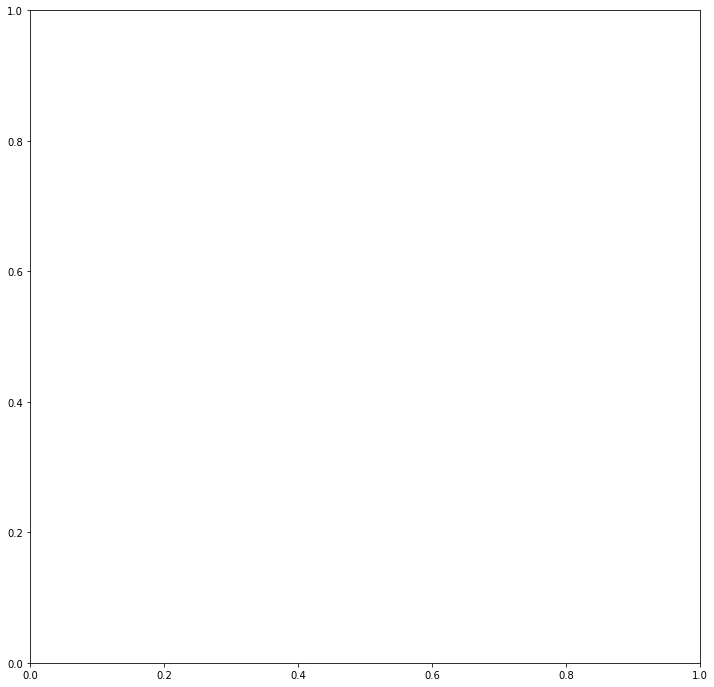

In [115]:
# UVP = copy.deepcopy(uvp)
# BLP = copy.deepcopy(blp_reds.values())
# UVP = UVP.average_spectra(blpair_groups=BLP, inplace=False)

# BLPg = [bl[0] for bl in BLP]

# f, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(12, 12))
# hp.plot.delay_spectrum(
#     UVP,
#     BLPg,
#     0,
#     'xx',
#     average_blpairs=False,
#     average_times=True,
#     fold=True,
#     plot_noise=True,
#     delay=False,
#     deltasq=False,
#     legend=True,
#     ax=ax,
#     component='abs',
#     lines=True,
#     markers=False,
#     error=None)
# ax.legend(loc='upper right', ncol=3)

In [110]:
# Average each UVPspec object in time and baseline bin and fold into wedge
for uvp, norm in zip(uvps, norms):
    blpairs = [[(bl, bl) for bl in bls_reds[norm]]]
    uvp.average_spectra(blpair_groups=blpairs, time_avg=True)
    uvp.fold_spectra()
    uvp.data_array[0] = uvp.data_array[0].reshape(
        (len(uvp.freq_array)))[np.nonzero(uvp.data_array[0].reshape((len(uvp.freq_array))))]

In [111]:
# Load data from UVPspec objects into an array
wedge = np.array([uvp.data_array[0] for uvp in uvps])

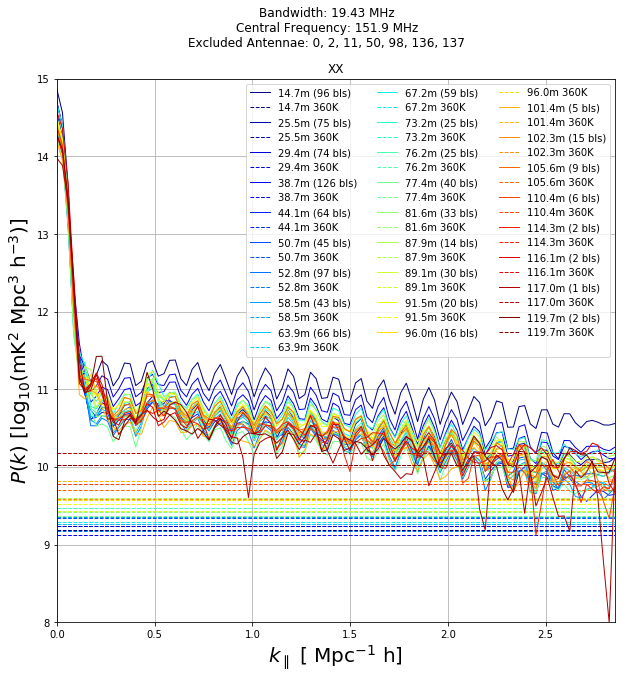

In [112]:
"""Plotting"""
def get_cmap(n, name='jet'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(len(uvps))

# Make a copy of a uvp object to get freq_array and kparas
UVP = copy.deepcopy(uvps[0])

# Find bandwidth and central frequency in MHz for naming
BAND_START = (UVP.freq_array[0] * u.Hz).to(u.MHz)
BAND_STOP = (UVP.freq_array[-1] * u.Hz).to(u.MHz)
BANDWIDTH = (BAND_STOP - BAND_START)
CENTRAL_FREQ = ((BANDWIDTH / UVP.Nfreqs) + BAND_START)

# Generate x-values to plot against
kparas = (UVP.get_kparas(0)/u.Mpc).insert(0, 0)

Tsys = 360
plt.figure(figsize=(10, 10))
for i, (uvp, norm, pspec) in enumerate(zip(uvps, norms, wedge)):
    plt.plot(
        kparas,
        np.log10(np.abs(pspec)),
        c=cmap(i),
        ls='-',
        lw=1,
        label='{norm}m ({bls} bls)'.format(norm=norm, bls=len(bls_reds[norm])))

    noise = uvp.generate_noise_spectra(0, 'xx', Tsys)
    noise = noise[noise.keys()[0]]
    noise = np.insert(noise, 0, noise[0, 0], axis=1)
    noise = noise.reshape(len(kparas))
    noise = np.log10(noise)
    plt.plot(
        kparas,
        noise,
        c=cmap(i),
        ls='--',
        lw=1,
        label='{norm}m {Tsys}K'.format(norm=norm, Tsys=Tsys))
    
    
plt.legend(loc='upper right', ncol=3)

# x-axis
plt.xlim((0, UVP.get_kparas(0)[-1]))
plt.xlabel(r"$k_{\parallel}\ [\rm\ Mpc^{-1}\ h]$", size=20)

# y-axis
plt.ylim((8, 15))
plt.ylabel(r"$P(k)\ \rm [\log_{10}({mK^2\ Mpc^3\ h^{-3}})]$", size=20)

# Titles
plt.title("XX")
plt.suptitle("Bandwidth: {BW}\nCentral Frequency: {CF}\nExcluded Antennae: {XANTS}".format(
    BW=np.round(BANDWIDTH, 2),
    CF=np.round(CENTRAL_FREQ, 1),
    XANTS=', '.join([str(xant) for xant in xants])))

# Save and show the plot with a grid
plt.grid()
plt.savefig("zen.{JD}.{JD0}_{JDf}.xx.HH{DFext}.pdf".format(
    BW=np.round(BANDWIDTH.value, 2),
    CF=np.round(CENTRAL_FREQ.value, 1),
    JD=files[0].split(".")[1],
    JD0=files[0].split(".")[2],
    JDf=files[-1].split(".")[2],
    DFext=os.path.splitext(files[0])[1]))
plt.show()

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.imshow(np.log10(np.abs(wedge)), interpolation="nearest", aspect="auto")

# plt.tick_params(axis='both', direction='inout')

# plt.xticks([])
# plt.xlabel(str(norms[i]) + " m", rotation=45, ha="center")

# horizon = ((norms[i]*u.m / c.c).to(u.ns)).value
# plt.axhline(y=horizon, color="w", ls=":")
# plt.axhline(y=-horizon, color="w", ls=":")

# plt.ylim((uvp.get_dlys(0)[0]*1e9 / 2., uvp.get_dlys(0)[-1]*1e9 / 2.))
    
# plt.text(0.07, 0.5, r"$\tau$ [ns]", ha="center", rotation="vertical", size=20)
# plt.text(0.5, 0.04, "Redundant Baseline Group", ha="center", size=20)
# plt.subplots_adjust(wspace=0, hspace=0)
# cbar_ax = fig.add_axes([0.9125, 0.25, 0.025, 0.5])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=20, ha='center')
# plt.show()
# plt.clf()

In [ ]:
# Plot each baselines divided by or subtracted by its noise estimate in 2d wedge format